In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import json
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [2]:
%matplotlib inline

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [13]:
df = pd.read_csv('obj-det/Training/train.csv')
df.set_index('image', inplace=True)
final_boxes = []
w_box = []
h_box = []
for img in df.index:
  current_image = Image.open('obj-det/Training/'+img)
  width, height = current_image.size
  box = json.loads(df.loc[img]['tips'])
  boxes = []
  for item in box:
    xmin = int(item.get('x1'))
    ymin = int(item.get('y1'))
    xmax = int(item.get('x2'))
    ymax = int(item.get('y2'))
    coors = [xmin, ymin, xmax, ymax]
    boxes.append(coors)
  final_boxes.append(boxes)
  w_box.append(width)
  h_box.append(height)
df['box'] = final_boxes
df['height'] = w_box
df['width'] = h_box


In [24]:
df.head()

,filename,tips,box,height,width,xmin,ymin,xmax,ymax,class
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[1570, 833, 1711, 974]",2560,1920,1570,833,1711,974,tip
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[177, 980, 318, 1121]",2560,1920,177,980,318,1121,tip
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[787, 727, 928, 868]",2560,1920,787,727,928,868,tip
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[74, 694, 215, 835]",2560,1920,74,694,215,835,tip
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[1827, 646, 1968, 787]",2560,1920,1827,646,1968,787,tip


[446, 1420, 587, 1561]
[851, 1288, 992, 1429]
[871, 1293, 1012, 1434]
[984, 693, 1125, 834]
[1146, 304, 1287, 445]
[1275, 421, 1416, 562]
[805, 979, 946, 1120]
[913, 969, 1054, 1110]


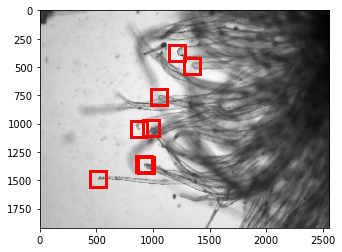

In [25]:
b = df.loc[df['filename'] == 'GH_30.jpg']['box']
for label in b:
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = label
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
plt.imshow(img_array, cmap='gray')
plt.show()

In [14]:
df.head()

,tips,box,height,width
image,,,,
GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[[1570, 833, 1711, 974], [177, 980, 318, 1121]...",2560,1920
GH_1.jpg,"[{""x1"": 1794, ""y1"": 1497, ""x2"": 1935, ""y2"": 16...","[[1794, 1497, 1935, 1638], [2334, 1088, 2475, ...",2560,1920
GH_2.jpg,"[{""x1"": 1650, ""y1"": 496, ""x2"": 1791, ""y2"": 637...","[[1650, 496, 1791, 637], [1879, 897, 2020, 103...",2560,1920
GH_3.jpg,"[{""x1"": 360, ""y1"": 877, ""x2"": 501, ""y2"": 1018}...","[[360, 877, 501, 1018], [288, 1113, 429, 1254]...",2560,1920
GH_4.jpg,"[{""x1"": 1351, ""y1"": 609, ""x2"": 1492, ""y2"": 750...","[[1351, 609, 1492, 750], [1171, 1108, 1312, 12...",2560,1920


In [15]:
df.reset_index(inplace=True)

In [16]:
df = df.explode('box')

In [17]:
df.head()

,image,tips,box,height,width
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[1570, 833, 1711, 974]",2560,1920
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[177, 980, 318, 1121]",2560,1920
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[787, 727, 928, 868]",2560,1920
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[74, 694, 215, 835]",2560,1920
0,GH_0.jpg,"[{""x1"": 1570, ""y1"": 833, ""x2"": 1711, ""y2"": 974...","[1827, 646, 1968, 787]",2560,1920


In [18]:
df['xmin'] = [x[0] for x in df['box']]
df['ymin'] = [x[1] for x in df['box']]
df['xmax'] = [x[2] for x in df['box']]
df['ymax'] = [x[3] for x in df['box']]
df['class'] = 'tip'
df.rename({'image':'filename'}, axis=1, inplace=True)

In [21]:
final_df = df[['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']]

In [22]:
final_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,GH_0.jpg,1920,2560,tip,1570,833,1711,974
0,GH_0.jpg,1920,2560,tip,177,980,318,1121
0,GH_0.jpg,1920,2560,tip,787,727,928,868
0,GH_0.jpg,1920,2560,tip,74,694,215,835
0,GH_0.jpg,1920,2560,tip,1827,646,1968,787


In [ ]:
val_df = final_df.loc[final_df['filename'].isin(['GH_430.jpg', 'GH_431.jpg', 'GH_432.jpg', 'GH_433.jpg', 'GH_434.jpg'])]

In [ ]:
final_df = final_df.drop(val_df.index)

In [ ]:
grouped = final_df.groupby('filename')

In [ ]:
grouped.apply(lambda x: len(x)).value_counts()

In [ ]:
gb = final_df.groupby('filename')

In [ ]:
grouped_list = [gb.get_group(x) for x in gb.groups]

In [ ]:
train = pd.concat([grouped_list[i] for i in range(0,len(grouped_list))])

In [ ]:
train.to_csv('train_labels.csv', index=None)

In [ ]:
grouped_val = val_df.groupby('filename')
gb_val = val_df.groupby('filename')
grouped_list = [gb_val.get_group(x) for x in gb_val.groups]
val = pd.concat([grouped_list[i] for i in range(0,len(grouped_list))])

In [ ]:
val.to_csv('val_labels.csv', index=None)

In [ ]:
# Generating TensorFlow Dataset from the train data
!python generate_tfrecord.py --csv_input=obj-det/Data/train_labels.csv --output_path=obj-det/Data/train.record --image_dir=obj-det/Training

In [ ]:
# Generating TensorFlow Dataset from the validation data
!python generate_tfrecord.py --csv_input=val_labels.csv --output_path=obj-det/Data/val.record --image_dir=obj-det/Validation

In [ ]:
# Checking for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
tf.__version__

In [3]:
# Printing available compute devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2906438976639597420
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4419674545827143685
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951408640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 303811332186464945
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17075461877266148044
physical_device_desc: "device: XLA_GPU device"
]


In [ ]:
# Setting path for object detection protos
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
#%set_env PYTHONPATH=/object_detection/models/research:/object_detection/models/research/slim

In [ ]:
# import os
# os.environ['PYTHONPATH'] += ":/object_detection/models"
# import sys
# sys.path.append("/object_detection/models")

In [ ]:
# Code to fitting the model with the training data
!python model_main_tf2.py --model_dir=obj-det/trained-model-retnet50 --pipeline_config_path=obj-det/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config --sample_1_of_n_eval_examples=1 --logtostderr

In [ ]:
# Code to export the trained model
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path obj-det/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config --trained_checkpoint_dir obj-det/trained-model-retnet50/ --output_directory new_graph_retnet50 --use_side_inputs False

In [4]:
# Code block to retrieve the model from the checkpoint
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = "new_graph_retnet50/pipeline.config"
PATH_TO_CKPT = "new_graph_retnet50/checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 1.4208478927612305 seconds


In [5]:
type(detection_model)

object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

# Setting path to the image classes
PATH_TO_LABELS = 'obj-det/Data/object-detection.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
IMAGE_PATHS = [i for i in glob.glob('obj-det\\Testing\\*.{}'.format('jpg'))]

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    # Predicting the boxes with the custom trained model
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    # Visualizing the image and the predicted boxes
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
    # Saving the detection predictions
    plt.savefig('test_pred_retnet50/{}_pred.png'.format(image_path.split('\\')[2].split('.')[0]))
    plt.show()

Running inference for obj-det\Testing\Test_GH_0.jpg... Done
Running inference for obj-det\Testing\Test_GH_1.jpg... Done
Running inference for obj-det\Testing\Test_GH_10.jpg... Done
Running inference for obj-det\Testing\Test_GH_11.jpg... Done
Running inference for obj-det\Testing\Test_GH_12.jpg... Done
Running inference for obj-det\Testing\Test_GH_13.jpg... Done
Running inference for obj-det\Testing\Test_GH_14.jpg... Done
Running inference for obj-det\Testing\Test_GH_15.jpg... Done
Running inference for obj-det\Testing\Test_GH_16.jpg... Done
Running inference for obj-det\Testing\Test_GH_17.jpg... Done
Running inference for obj-det\Testing\Test_GH_18.jpg... Done
Running inference for obj-det\Testing\Test_GH_19.jpg... Done
Running inference for obj-det\Testing\Test_GH_2.jpg... Done
Running inference for obj-det\Testing\Test_GH_20.jpg... Done
Running inference for obj-det\Testing\Test_GH_21.jpg... Done
Running inference for obj-det\Testing\Test_GH_22.jpg... Done
Running inference for obj-d